In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'font.size': 10})
from collections import defaultdict
import cPickle as pickle
import numpy as np
import argparse
import os
import matplotlib.pyplot as pyplot
import colorbrewer as cb
from scipy.stats import pearsonr
import fnmatch


def list_files_or_dir(file_or_dir_list, suffix='*', containing='*'):
    if type(file_or_dir_list) != list: return file_or_dir_list
    files = []
    for file_or_dir in file_or_dir_list:
        if os.path.isdir(file_or_dir):
            for root, dirnames, filenames in os.walk(file_or_dir):
                for filename in fnmatch.filter(filenames, '*%s*%s' % (containing, suffix)):
                    files.append(os.path.join(root, filename))
        else:
            files.append(file_or_dir)
    return files


def save_or_show(plotpath=None, name=None, exten='png'):
    if plotpath:
        if os.path.isdir(plotpath):
            plot_base_path, plot_name = plotpath, name
        else:
            plot_base_path, plot_name = os.path.split(plotpath)
            if not os.path.exists(plot_base_path):
                os.makedirs(plot_base_path)
            if not plot_name:
                plot_name = name
        pyplot.savefig("%s/%s.%s"%(plot_base_path, plot_name, exten), width=300, height=300, dpi=100)
        print "Saved in:\n%s/%s.%s" % (plot_base_path, plot_name, exten)

        pyplot.clf()
    else:
        pyplot.show()

        
def collapse_matrix(matrix):
    """Collapse the diagonals probabilities in 1-D and return them"""
    collapse = []
    matrix_corner = matrix.shape[0]
    for i in xrange(-matrix_corner+1, matrix_corner):
        collapse.append(np.diagonal(matrix, offset=i).sum())

    return np.array(collapse)
        
        
def get_color(tissue):
    colors_dict = {
        'rest_stim': '#%02x%02x%02x' % cb.Paired[10][-1],
        'cer_liv': '#%02x%02x%02x' % cb.Paired[10][-3]
    }
    return colors_dict[tissue]


def scatterplot_rtpcr_majiq_miso(rt_pcr, majiq, miso, cov, plotpath, pcr_majiq_extra=None, pcr_miso_extra=None, majiq_extra=None, miso_extra=None):
    fig, axx = pyplot.subplots(2, 3, sharex=True, sharey=True, figsize=[9, 6], dpi=300)
    fig.suptitle("DeltaPSI comparison: RT-PCR Vs MAJIQ; RT-PCR Vs MISO")
    diagonal = np.linspace(-1, 1, num=len(rt_pcr))
    axx[0][0].plot(diagonal, diagonal, '--', color="#cccccc")

    fit = np.polyfit(np.append(majiq, majiq_extra), np.append(rt_pcr, np.array(pcr_majiq_extra)), 1)
    fit_fn = np.poly1d(fit)  # fit_fn is now a function which takes in x and returns an estimate for y

    axx[0][0].plot(np.append(majiq, majiq_extra), fit_fn(np.append(majiq, majiq_extra)), '--k')
    axx[0][0].plot(majiq, rt_pcr, '.', color=get_color('rest_stim'), label='Unstim Vs Stim')
    axx[0][0].plot(majiq_extra, pcr_majiq_extra, 'd', color=get_color('cer_liv'), label='Hogenesch Cer Vs Liv')
    pearson_r = pearsonr(np.append(majiq, majiq_extra), np.append(rt_pcr, pcr_majiq_extra))[0]
    axx[0][0].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)


    axx[0][0].set_xlabel('MAJIQ')
    axx[0][0].set_ylabel('RT-PCR')
    axx[0][0].set_title('All (N=%d)' % (len(majiq) + len(majiq_extra)))
    axx[0][0].set_xlim([-1,1])
    axx[0][0].set_ylim([-1,1])
    diagonal = np.linspace(-1, 1, num=len(rt_pcr))
    fit = np.polyfit(np.append(miso, miso_extra), np.append(rt_pcr, np.array(pcr_miso_extra)), 1)
    fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y

    axx[1][0].plot(np.append(miso, miso_extra), fit_fn(np.append(miso, miso_extra)), '--k')
    axx[1][0].plot(diagonal, diagonal, '--', color="#cccccc")
    axx[1][0].plot(miso, rt_pcr, '.', color=get_color('rest_stim'), label='Unstim Vs Stim')
    axx[1][0].plot(miso_extra, pcr_miso_extra, 'd', color=get_color('cer_liv'), label='Hogenesch Cer Vs Liv')
    pearson_r = pearsonr(np.append(miso, miso_extra), np.append(rt_pcr, pcr_miso_extra))[0]
    axx[1][0].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)


    axx[1][0].set_xlabel('MISO')
    axx[1][0].set_ylabel('RT-PCR')
    axx[1][0].set_title('All (N=%d)' % (len(miso) + len(miso_extra)))
    axx[1][0].set_xlim([-1,1])
    axx[1][0].set_ylim([-1,1])
    diagonal = np.linspace(-1, 1, num=len(rt_pcr))
    fit = np.polyfit(majiq, rt_pcr, 1)
    fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y

    axx[0][1].plot(majiq, fit_fn(majiq), '--k')
    axx[0][1].plot(diagonal, diagonal, '--', color="#cccccc")
    axx[0][1].plot(majiq, rt_pcr, '.', color=get_color('rest_stim'), label='Unstim Vs Stim')
    pearson_r = pearsonr(majiq, rt_pcr)[0]
    axx[0][1].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)
    axx[0][1].set_xlabel('MAJIQ')
    axx[0][1].set_ylabel('RT-PCR')
    axx[0][1].set_title('Unstim Vs Stim (N=%d)' % len(majiq))
    axx[0][1].set_xlim([-1, 1])
    axx[0][1].set_ylim([-1, 1])

    fit = np.polyfit(majiq_extra, pcr_majiq_extra, 1)
    fit_fn = np.poly1d(fit)
    axx[0][2].plot(majiq_extra, fit_fn(majiq_extra), '--k')
    axx[0][2].plot(diagonal, diagonal, '--', color="#cccccc")
    axx[0][2].plot(majiq_extra, pcr_majiq_extra, 'd', color=get_color('cer_liv'), label='Hogenesch Cer Vs Liv')
    pearson_r = pearsonr(majiq_extra, pcr_majiq_extra)[0]
    axx[0][2].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)


    axx[0][2].set_xlabel('MAJIQ')
    axx[0][2].set_ylabel('RT-PCR')
    axx[0][2].set_title('Cerebellum Vs Liver (N=%d)' % len(majiq_extra))
    axx[0][2].set_ylim([-1,1])
    fit = np.polyfit(miso, rt_pcr, 1)
    fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y

    axx[1][1].plot(miso, fit_fn(miso), '--k')
    axx[1][1].plot(diagonal, diagonal, '--', color="#cccccc")
    axx[1][1].plot(miso, rt_pcr, '.', color=get_color('rest_stim'), label='Unstim Vs Stim')
    pearson_r = pearsonr(miso, rt_pcr)[0]
    axx[1][1].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)
    axx[1][1].set_xlabel('MISO')
    axx[1][1].set_ylabel('RT-PCR')
    axx[1][1].set_title('Unstim Vs Stim (N=%d)' % len(miso))
    axx[1][1].set_xlim([-1, 1])
    axx[1][1].set_ylim([-1, 1])

    fit = np.polyfit(miso_extra, pcr_miso_extra, 1)
    fit_fn = np.poly1d(fit)
    axx[1][2].plot(miso_extra, fit_fn(miso_extra), '--k')
    axx[1][2].plot(diagonal, diagonal, '--', color="#cccccc")
    axx[1][2].plot(miso_extra, pcr_miso_extra, 'd', color=get_color('cer_liv'), label='Hogenesch Cer Vs Liv')
    pearson_r = pearsonr(miso_extra, pcr_miso_extra)[0]
    axx[1][2].text(-.9, .7, 'R=%.2f' % pearson_r, fontsize=14)
    axx[1][2].set_xlabel('MISO')
    axx[1][2].set_ylabel('RT-PCR')
    axx[1][2].set_title('Cerebellum Vs Liver (N=%d)' % len(miso_extra))
    axx[1][2].set_ylim([-1,1])
#     save_or_show(plotpath, "dpsi_rtpcr_majiq_miso", exten='pdf')


def scatterplot_rtpcr_simple(rt_pcr, method_epsis, cov,  plotpath, rt_pcr_extra=None, method_extra=None, cov_extra=None, plotname='psi_rtpcr', met_name='MAJIQ'):
    #figure out how many groups of events exist
    # Changing events
    CHANGE = .2
    rt_pcr_chg_mask = abs(rt_pcr) > CHANGE
    rt_pcr_extra_chg_mask = abs(rt_pcr_extra) > CHANGE
    method_chg_mask = abs(method_epsis) > CHANGE
    method_extra_chg_mask = abs(method_extra) > CHANGE

    kristen_false_pos = np.count_nonzero(~rt_pcr_chg_mask & method_chg_mask)
    hogenesch_false_pos = np.count_nonzero(~rt_pcr_extra_chg_mask & method_extra_chg_mask)
    print "%s [Kristen] false positive: %.2f%%" % (met_name, 100.*kristen_false_pos/rt_pcr_chg_mask.size)
    print "%s [Hogenesch] false positive: %.2f%%" % (met_name, 100.*hogenesch_false_pos/rt_pcr_extra_chg_mask.size)
    print "%s [all] false positive: %.2f%%" % (met_name, 100.*(kristen_false_pos + hogenesch_false_pos)/(rt_pcr_chg_mask.size + rt_pcr_extra_chg_mask.size))

    kristen_false_neg = np.count_nonzero(rt_pcr_chg_mask & ~method_chg_mask)
    hogenesch_false_neg = np.count_nonzero(rt_pcr_extra_chg_mask & ~method_extra_chg_mask)
    print "%s [Kristen] false negative: %.2f%%" % (met_name, 100.*kristen_false_neg / rt_pcr_chg_mask.size)
    print "%s [Hogenesch] false negative: %.2f%%" % (met_name, 100.*hogenesch_false_neg / rt_pcr_extra_chg_mask.size)
    print "%s [all] false negative: %.2f%%" % (met_name, 100.*(kristen_false_neg + hogenesch_false_neg) / (rt_pcr_chg_mask.size + rt_pcr_extra_chg_mask.size))

    # Coverage breakdown (used for coloring)
    cov_thres = [0, 30, 80, 100000]
    cov_colors = cb.Accent[3]

    fig = pyplot.figure(figsize=[6, 6], dpi=300)
    fig.suptitle("RT-PCR PSI comparison")


    diagonal = np.linspace(-1, 1, num=len(rt_pcr))
    fit = np.polyfit(np.concatenate((method_epsis[rt_pcr_chg_mask], method_extra[rt_pcr_extra_chg_mask])), np.concatenate((rt_pcr[rt_pcr_chg_mask], rt_pcr_extra[rt_pcr_extra_chg_mask])), 1)
    fit_fn = np.poly1d(fit) # fit_fn is now a function which takes in x and returns an estimate for y

    pyplot.plot(np.concatenate((method_epsis, method_extra)), fit_fn(np.concatenate((method_epsis, method_extra))), '--k')
    pyplot.plot(diagonal, diagonal, '--', color="#cccccc")
    pearson_r = pearsonr(np.append(method_epsis[rt_pcr_chg_mask], method_extra[rt_pcr_extra_chg_mask]), np.append(rt_pcr[rt_pcr_chg_mask], rt_pcr_extra[rt_pcr_extra_chg_mask]))[0]
    pyplot.text(-.9, .8, 'R=%.2f%%' % pearson_r, fontsize=14)

    for cov_idx, cov_th in enumerate(cov_thres[1:]):
        cov_mask = (cov > cov_thres[cov_idx]) & (cov <= cov_th)
        cov_extra_mask = (cov_extra > cov_thres[cov_idx]) & (cov_extra <= cov_th)
        pyplot.plot(method_epsis[cov_mask & rt_pcr_chg_mask], rt_pcr[cov_mask & rt_pcr_chg_mask], '.',
                    color='#%02x%02x%02x' % cb.Paired[10][-1],
                    label='Unst Vs Stim - Cov (%d, %d],N=%d' % (cov_thres[cov_idx], cov_th, np.count_nonzero(cov_mask & rt_pcr_chg_mask)))
        pyplot.plot(method_extra[cov_extra_mask & rt_pcr_extra_chg_mask], rt_pcr_extra[cov_extra_mask & rt_pcr_extra_chg_mask], 'd',
                    color='#%02x%02x%02x' % cb.Paired[10][-3],
                    label='Cer Vs Liv - Cov (%d, %d],N=%d' % (cov_thres[cov_idx], cov_th, np.count_nonzero(cov_extra_mask & rt_pcr_extra_chg_mask)))

    pyplot.xlabel(met_name)
    pyplot.ylabel('RT-PCR')
    pyplot.title('All (N=%d)' % (np.count_nonzero(rt_pcr_chg_mask) + np.count_nonzero(rt_pcr_extra_chg_mask)))
    pyplot.xlim([-1, 1])
    pyplot.ylim([-1, 1])
    pyplot.legend(loc='lower right', fontsize=7)
#     save_or_show(plotpath, plotname, exten='pdf')

    
def get_expected_dpsi(bins):
    return sum(np.array(bins) * np.arange(-1+1./len(bins), 1., 2./len(bins)))


def expected_psi(bins):
    bins = np.array(bins)
    step = 1.0 / bins.size
    projection_prod = bins * np.arange((1.*step) / 2, 1, step)
    return np.sum(projection_prod)


def avg_expected_psi(bins_list):
    return np.mean([expected_psi(bins) for bins in bins_list])


def get_variance(bins, mean):
    """Compute the variance = E[X^2] - (E[X])^2"""
    bins = np.array(bins)
    step_bins = 1 / bins.size
    projection_prod = bins * np.arange(step_bins / 2, 1, step_bins)**2
    return np.sum(projection_prod) - mean**2

def var_expected_psi(bins_list):
    return np.mean([expected_psi(bins) for bins in bins_list])


def expected_avg_psi(bins_list):
    return expected_psi(np.mean(bins_list, axis=0))


def expected_delta_psi(bins_list, rtpcr_psi):
    step = 1.0 / 40
    bins_index = np.arange(step / 2, 1, step)
    return np.mean([np.sum([bins[i]*abs(psi - rtpcr_psi) for i, psi in enumerate(bins_index)]) for bins in bins_list])


def parse_rtpcr_results(pcr_file, names_pcr2majiq_dict):
    pcr_rest_stim = defaultdict(list)
    with open(pcr_file, 'r') as pcr_file:
        for i, pcr_line in enumerate(pcr_file):
            if i<1 or pcr_line.startswith('#'): continue  # headers
            pcr_fields = pcr_line.rstrip().split('\t')
            # print pcr_fields
            if pcr_fields[0] not in names_pcr2majiq_dict.keys():
                continue  # If the event is not in the list of events selected, skip it
            try:
                pcr_rest_stim[pcr_fields[0]].append((float(pcr_fields[1]) - float(pcr_fields[2]))/100)
            except IndexError:
                print "%s value not found, assigned 0..." % pcr_fields[0]
                pcr_rest_stim[pcr_fields[0]].append(0)
            except ValueError, e:
                print e.message
                print "Event PSI could not be converted into float, wrong parsing??"
                pcr_rest_stim[pcr_fields[0]].append(0)
    print "Number of events found in RT-PCR file: %d" % len(pcr_rest_stim)
    return pcr_rest_stim


def parse_majiq_results(files_majiq, names_junc_majiq):
    majiq_dict = defaultdict(list)
    for mfile in files_majiq:
        with open(mfile) as mfile_open:
            mpickle = pickle.load(mfile_open)
            for i, lsv in enumerate(mpickle.lsvs):
                if lsv.get_id() not in names_junc_majiq.keys():
                    continue # If the event is not in the list of events selected, skip it

                jcoords_lsv = [jvisual.coords for jvisual in lsv.lsv_graphic.get_junctions()]
                # Find all junctions from that LSV that are included
                for jj, jcoords in enumerate(names_junc_majiq[lsv.get_id()]):
                    j = jcoords_lsv.index(jcoords[:2])
                    target_bins = None
                    try:
                        target_bins = np.array(lsv.get_bins()[j])
                        if target_bins.shape == (20, 20):
                            target_bins = collapse_matrix(target_bins)
                    except IndexError:
                        target_bins = np.array(lsv.get_bins()[0])
                        if target_bins.shape == (20, 20):
                            target_bins = collapse_matrix(target_bins)
                        target_bins = target_bins[::-1]
                    majiq_dict[lsv.get_id()+"#"+str(jcoords[2])].append(target_bins)                

    print "Number of events found in MAJIQ %s: %d" % ("; ".join([mf for mf in files_majiq]), len(majiq_dict.keys()))
    return majiq_dict


def parse_miso_results(files_miso, names_junc_majiq):
    miso_dict = defaultdict(list)
    files_miso = list_files_or_dir(files_miso)

    for mfile in files_miso:
        with open(mfile) as mfile_open:
            for line in mfile_open:
                miso_fields = line.rstrip().split()
                if miso_fields[0] not in names_junc_majiq.keys(): continue # If the event is not in the list of events selected, skip it

                lsv_name = miso_fields[0]
                miso_psis = miso_fields[1]
                # Find all junctions from that LSV that are included

                for i, miso_psi in enumerate(miso_psis.split(',')):
                    miso_dict[lsv_name+"#"+str(i)].append(float(miso_psi))

    print "Number of events found in MISO %s: %d" % ("; ".join([mf for mf in files_miso]), len(miso_dict.keys()))
    return miso_dict


def load_coverage(lcov_met1, lcov_met2, clean_reads_files, dataset='ho'):
    misannotated = {}
    misannotated['ENSMUSG00000031996:31153414-31153499:source'] = 'ENSMUSG00000031996:31153414-31153501:source'
    misannotated['ENSMUSG00000024830:4161068-4161215:target'] = 'ENSMUSG00000024830:4161064-4161215:target'
    cov1_ll = [[0, 0] for ii in xrange(len(lcov_met1))]
    cov2_ll = [[0, 0] for ii in xrange(len(lcov_met2))]
    for crf_ix, clean_reads_file in enumerate(clean_reads_files):
        with open(clean_reads_file) as clean_reads_f:
            for clean_reads in pickle.load(clean_reads_f):
                if dataset == 'ho' and clean_reads[0] in misannotated.keys():
                    clean_reads[0] = misannotated[clean_reads[0]]
                try:
                    # lcov_met1[lcov_met1.index(clean_reads[0])] = clean_reads[1].sum()
                    cov1_ll[lcov_met1.index(clean_reads[0])][crf_ix] = clean_reads[1].sum()
                except ValueError:
                    pass
                try:
                    # lcov_met2[lcov_met2.index(clean_reads[0])] = clean_reads[1].sum()
                    cov2_ll[lcov_met2.index(clean_reads[0])][crf_ix] = clean_reads[1].sum()
                except ValueError:
                    pass
    lcov_met1 = np.average(cov1_ll, axis=1)
    try:
        lcov_met2 = np.average(cov2_ll, axis=1)
    except IndexError:
        pass
    return lcov_met1, lcov_met2


def main(args_to_parse=None):
    parser = argparse.ArgumentParser(description="Compare PSIs computed with MAJIQ against the RT-PCR results.")
    parser.add_argument("pcr", help="Tab-delimted file with the RT-PCR scores")
    parser.add_argument("--majiq-rest-stim", required=True, dest='majiq_rest_stim', nargs=1, help='MAJIQ delta PSI predictions for Unstim Vs Stim RNA-Seq data.')
    parser.add_argument("--miso-rest", dest='miso_rest', nargs='*', help='MISO PSI predictions for resting RNA-Seq data.')
    parser.add_argument("--miso-stim", dest='miso_stim', nargs='*', help='MISO PSI predictions for stimulated RNA-Seq data.')
    parser.add_argument("--names-map-file", required=True, dest='names_map_file', help='File containing the mapping for events names used in MAJIQ and RT-PCR files.')
    parser.add_argument("--clean-reads", dest='clean_reads', nargs=2, help='Clean reads from MAJIQ quantifications (one file per condition).')

    parser.add_argument("--majiq-extra", dest='majiq_extra', nargs=1, help='MAJIQ PSI predictions for extra conditions.')
    parser.add_argument("--miso-extra", dest='miso_extra', nargs='+', help='MISO PSI predictions for extra conditions.')
    parser.add_argument("--pcr-extra", dest='pcr_extra', help='RT-PCR validations for extra conditions.')
    parser.add_argument("--clean-reads-extra", dest='clean_reads_extra', nargs=2, help='Clean reads from MAJIQ quantifications (one file per condition).')

    parser.add_argument('--plotpath', default='output')
    
    if args_to_parse is not None:
        args = parser.parse_args(args_to_parse)
    else:
        args = parser.parse_args()

    ## ------------------------ ##
    ## Hogenesch data
    ## ------------------------ ##
    lrtpcr_majiq_extra = []
    lrtpcr_miso_extra = []
    lmajiq_extra = []
    lmiso_extra = []
    lcov_majiq_extra = []
    lcov_miso_extra = []

    if args.majiq_extra:
        # 1. Read PCR results
        rtpcr_extra = defaultdict(list)
        with open(args.pcr_extra) as pcr_extra:
            for pcr_elem in pcr_extra:
                if pcr_elem.startswith("#"): continue
                pcr_elems=pcr_elem.rstrip().split()
                rtpcr_extra[pcr_elems[0].split("#")[0]] = [float(pcr_elems[2])/100, np.nan, [], [], float(pcr_elems[6])/100, float(pcr_elems[5])/100, pcr_elems[-4]]


        # Read Majiq results for the elements in PCR
        djunc_selected = {}

        rtpcr_extra['ENSMUSG00000031996:31153414-31153501:source'] = rtpcr_extra['ENSMUSG00000031996:31153414-31153499:source']
        del rtpcr_extra['ENSMUSG00000031996:31153414-31153499:source']
        rtpcr_extra['ENSMUSG00000024830:4161064-4161215:target'] = rtpcr_extra['ENSMUSG00000024830:4161068-4161215:target']
        del rtpcr_extra['ENSMUSG00000024830:4161068-4161215:target']

        for mfile in args.majiq_extra:
            majiq_found = []
            with open(mfile) as mfile_open:
                mpickle = pickle.load(mfile_open)
                for j, lsv in enumerate(mpickle.get_lsvs()):
                    if lsv.get_id() in rtpcr_extra:
                        majiq_found.append(lsv.get_id())
                        for lway_aux, lway_junc in enumerate(lsv.lsv_graphic.get_junctions()):
                            if set(lway_junc.get_coords()) == set([int(aa) for aa in rtpcr_extra[lsv.get_id()][-1].split('-')]):
                                lsv_aux = lsv.get_id() + "#%d"%lway_aux
                                djunc_selected[lsv.get_id()] = lway_aux
                                try:
                                    rtpcr_extra[lsv.get_id()][1] = -get_expected_dpsi(lsv.get_bins()[lway_aux])
                                except IndexError:
                                    rtpcr_extra[lsv.get_id()][1] = get_expected_dpsi(lsv.get_bins()[0])

        # Read MISO results for the elements in PCR
        for cn, miso_dir in enumerate(args.miso_extra):
            files_miso = list_files_or_dir([miso_dir], containing='miso')
            for mfile in files_miso:
                with open(mfile) as mfile_open:
                    for line in mfile_open:
                        miso_fields = line.rstrip().split()
                        lsv_name = miso_fields[0]
                        miso_psis = miso_fields[1].split(',')
                        miso_starts = miso_fields[-2].split(',')
                        miso_ends = miso_fields[-1].split(',')
                        if lsv_name in rtpcr_extra:
                            # Find all junctions from that LSV that are included
                            try:
                                rtpcr_extra[lsv_name][2+cn].append(float(miso_psis[djunc_selected[lsv_name]]))
                            except IndexError:
                                rtpcr_extra[lsv_name][2+cn].append(1-float(miso_psis[0]))
                            except KeyError:
                                print "[WARNING] :: %s in MISO, but not in MAJIQ, skipped given the impossibility of determining which junction it is." % lsv_name

        with open('dpsi_hogenesch.txt', 'w') as psi_txt:
            headers=['LSV ID', 'RT-PCR', 'Majiq', 'Miso Cerebellum', 'Miso Liver', 'RT-PCR Cerebellum Avg. STD', 'RT-PCR Liver Avg. STD']
            psi_txt.write('\t'.join(headers))
            psi_txt.write('\n')
            for ilsv, vals in rtpcr_extra.iteritems():
                line = [ilsv]
                line.extend([repr(vv) for vv in vals[:-1]])
                psi_txt.write("\t".join(line))
                psi_txt.write('\n')
                if not np.isnan(vals[1]):
                    lrtpcr_majiq_extra.append(vals[0])
                    lmajiq_extra.append(vals[1])
                    lcov_majiq_extra.append(ilsv)
                if not np.isnan(np.mean(vals[2])) and not np.isnan(np.mean(vals[3])):
                    lrtpcr_miso_extra.append(vals[0])
                    lmiso_extra.append(np.mean(vals[2]) - np.mean(vals[3]))
                    lcov_miso_extra.append(ilsv)
        # Find out coverage (clean reads) for each LSV junction)
        lcov_majiq_extra, lcov_miso_extra = load_coverage(lcov_majiq_extra, lcov_miso_extra, args.clean_reads_extra)

    ## ------------------------ ##
    ## Kristen's data
    ## ------------------------ ##
    names_pcr2majiq_dict = {}  # key RT-PCR, value MAJIQ
    names_majiq2pcr_dict = {}
    names_junc_majiq = defaultdict(list)
    gene_names_counts = defaultdict(lambda: 0)
    with open(args.names_map_file) as names_map:
        for name_map in names_map:
            # MAJIQ
            mapped_name = name_map.rstrip().split()
            majiq_name, junc_idx_old = mapped_name[1].split('#')
            names_junc_majiq[majiq_name].append([int(jcoord) for jcoord in mapped_name[-1].split('-')] + [int(junc_idx_old)])

            # RT-PCR
            names_pcr2majiq_dict[mapped_name[0]] = mapped_name[1]
            names_majiq2pcr_dict[mapped_name[1]] = mapped_name[0]
            gene_names_counts[mapped_name[0]] += 1

    print "Number of events in names-map-file RT-PCR: %d" % len(names_pcr2majiq_dict.keys())
    print "Number of events in names-map-file MAJIQ: %d" % len(names_junc_majiq.keys())

    # Parse RT-PCR results
    pcr_rest_stim = parse_rtpcr_results(args.pcr, names_pcr2majiq_dict)

    # Process MAJIQ files for resting RNA-Seq data
    majiq_rest_stim_dict = parse_majiq_results(args.majiq_rest_stim, names_junc_majiq)

    # Process MAJIQ files for resting RNA-Seq data
    miso_rest_dict = parse_miso_results(args.miso_rest, names_junc_majiq)

    # Process MAJIQ files for stimuli RNA-Seq data
    miso_stim_dict = parse_miso_results(args.miso_stim, names_junc_majiq)

    ## Intersect names from RT-PCR and MAJIQ
    common_names_set = set([names_pcr2majiq_dict[k] for k in pcr_rest_stim.keys()]).intersection(set(majiq_rest_stim_dict.keys()))
    print "Common names afer intersection with MAJIQ: %d" % len(common_names_set)
    common_names_set = common_names_set.intersection(set(miso_rest_dict.keys())).intersection(set(miso_stim_dict.keys()))
    print "Common names afer intersection with MISO: %d" % len(common_names_set)

    kr_rt_pcr_dpsi= []
    kr_majiq_dpsi = []
    kr_miso_dpsi = []
    kr_cov = []

    with open('dpsi_kristens.txt', 'w') as psi_txt:
        headers=['LSV ID', 
                 'RT-PCR', 
                 'Majiq', 
                 'Miso Stim.', 
                 'Miso Unstim.', 
                 'RT-PCR Stim. Avg. STD', 
                 'RT-PCR Liver Avg. STD']
        psi_txt.write('\t'.join(headers))
        psi_txt.write('\n')

        for common_name in common_names_set:
            for name_majiq, name_pcr in names_majiq2pcr_dict.iteritems():
                if names_majiq2pcr_dict[common_name] == name_pcr:
                    name = name_majiq
                    psi_txt_line = [name]

                    # For Majiq, compute mean over Expected PSIs
                    majiq_rest_stim_stat = get_expected_dpsi(majiq_rest_stim_dict[name][0])
                    # For MISO, compute mean
                    miso_rest_stat = np.mean(miso_rest_dict[name])
                    miso_stim_stat = np.mean(miso_stim_dict[name])

                    kr_rt_pcr_dpsi.append(pcr_rest_stim[names_majiq2pcr_dict[name]][0])
                    kr_majiq_dpsi.append(majiq_rest_stim_stat)
                    kr_miso_dpsi.append(miso_rest_stat-miso_stim_stat)
                    kr_cov.append(name.split("#")[0])
                    psi_txt_line.append(str(np.mean(kr_rt_pcr_dpsi[-1])))
                    psi_txt_line.append(str(kr_majiq_dpsi[-1]))
                    psi_txt_line.append(str(miso_rest_dict[name]))
                    psi_txt_line.append(str(miso_stim_dict[name]))
                    psi_txt_line.append(str(np.std(kr_rt_pcr_dpsi[-1])))
                    psi_txt.write('\t'.join(psi_txt_line))
                    psi_txt.write('\n')

    kr_cov, foo = load_coverage(kr_cov, [], args.clean_reads, dataset='kr')

    scatterplot_rtpcr_majiq_miso(np.array(kr_rt_pcr_dpsi), np.array(kr_majiq_dpsi), np.array(kr_miso_dpsi), np.array(kr_cov), args.plotpath,
                                 pcr_majiq_extra=np.array(lrtpcr_majiq_extra), pcr_miso_extra=np.array(lrtpcr_miso_extra), majiq_extra=np.array(lmajiq_extra),
                                 miso_extra=np.array(lmiso_extra))
    scatterplot_rtpcr_simple(np.array(kr_rt_pcr_dpsi), np.array(kr_majiq_dpsi), np.array(kr_cov), args.plotpath, rt_pcr_extra=np.array(lrtpcr_majiq_extra),
                             method_extra=np.array(lmajiq_extra), cov_extra=np.array(lcov_majiq_extra), plotname='dpsi_majiq_only', met_name='MAJIQ')
    scatterplot_rtpcr_simple(np.array(kr_rt_pcr_dpsi), np.array(kr_miso_dpsi), np.array(kr_cov), args.plotpath, rt_pcr_extra=np.array(lrtpcr_miso_extra),
                             method_extra=np.array(lmiso_extra), cov_extra=np.array(lcov_miso_extra), plotname='dpsi_miso_only', met_name='MISO')


Number of events in names-map-file RT-PCR: 93
Number of events in names-map-file MAJIQ: 94
Number of events found in RT-PCR file: 70
Number of events found in MAJIQ ../data/fig2_BC/Kristen/Unstim_Stim.deltapsi.pickle: 82
Number of events found in MISO ../data/fig2_BC/Kristen/miso/rest/resting_wt_1.miso_summary; ../data/fig2_BC/Kristen/miso/rest/resting_wt_2.miso_summary; ../data/fig2_BC/Kristen/miso/rest/resting_wt_3.miso_summary: 223
Number of events found in MISO ../data/fig2_BC/Kristen/miso/stim/stim_wt_1.miso_summary; ../data/fig2_BC/Kristen/miso/stim/stim_wt_2.miso_summary; ../data/fig2_BC/Kristen/miso/stim/stim_wt_3.miso_summary: 223
Common names afer intersection with MAJIQ: 56
Common names afer intersection with MISO: 55
MAJIQ [Kristen] false positive: 0.00%
MAJIQ [Hogenesch] false positive: 4.00%
MAJIQ [all] false positive: 1.87%
MAJIQ [Kristen] false negative: 15.79%
MAJIQ [Hogenesch] false negative: 2.00%
MAJIQ [all] false negative: 9.35%
MISO [Kristen] false positive: 0.00%

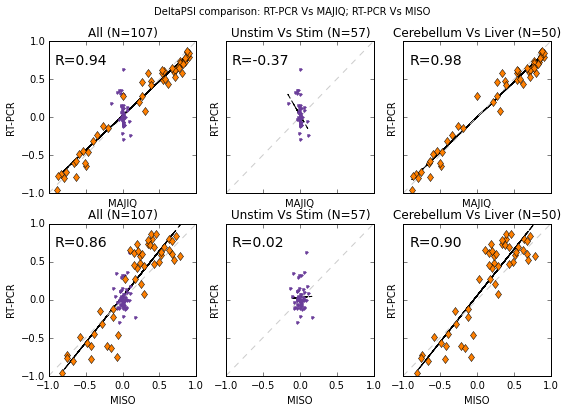

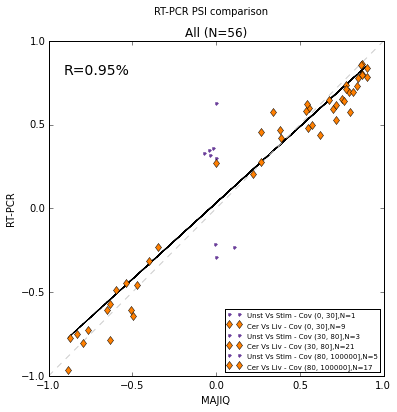

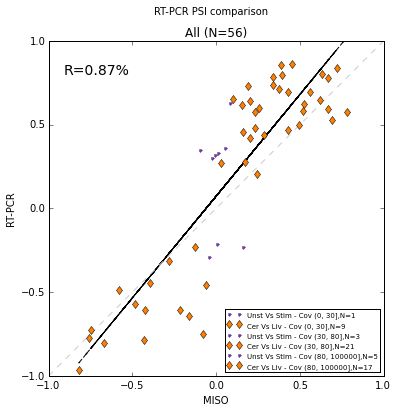

In [2]:
args_str = '../data/fig2_BC/rtPCR_comp/RTPCR_PSI_values --majiq-rest-stim ../data/fig2_BC/Kristen/Unstim_Stim.deltapsi.pickle --names-map-file ../data/fig2_BC/rtPCR_comp/pcr_junctions_Extra.test.tab --miso-rest ../data/fig2_BC/Kristen/miso/rest --miso-stim ../data/fig2_BC/Kristen/miso/stim --clean-reads ../data/fig2_BC/Kristen/clean_reads.Stim.pkl ../data/fig2_BC/Kristen/clean_reads.Unstim.pkl --pcr-extra ../data/fig2_BC/Hogenesch/Liv_v_Cer_RTPCR_by_replicate_final_with_JUNCTIONS.txt --majiq-extra ../data/fig2_BC/Hogenesch/Cer_CT284052_Liv_CT284052.deltapsi_quantify.pickle --miso-extra ../data/fig2_BC/Hogenesch/miso/Cer ../data/fig2_BC/Hogenesch/miso/Liv --clean-reads-extra ../data/fig2_BC/Hogenesch/clean_reads.Cer_284052.pkl ../data/fig2_BC/Hogenesch/clean_reads.Liv_284052.pkl --plotpath plots/fig2_BC/'
main(args_to_parse=args_str.split())